In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from datetime import datetime

### Data import

    test_fcast_qty.csv - Динамика продаж товаров (все артикулы из одной товарной категории)
    
    article_id - id артикула
    Qty - продано штук
    Date - дата создания заказа
    Country - страна
    FinResult - финансовый результат от продажи (выручка)
    test_fcast_stock.csv - Остатки на складе по артикулам
    article_id - id артикула
    Stock - остаток в штуках
    Date - дата записи остатка


In [2]:
sales_df = pd.read_csv('Test_DA_atd_pb/SCM_data/test_fcast_sales.csv')
print(sales_df.shape)
sales_df.head(5)

(868329, 5)


,Date,Country,Qty,FinResult,article_id
0,2018-12-02,IT,2,5.92,343
1,2018-12-04,BN,2,5.92,343
2,2018-12-02,FI,2,5.92,343
3,2018-12-08,IT,2,5.92,343
4,2018-12-05,SE,2,5.92,343


In [3]:
stock_df = pd.read_csv('Test_DA_atd_pb/SCM_data/test_fcast_stock.csv')
print(stock_df.shape)
stock_df.head(5)

(1647557, 3)


,Date,Stock,article_id
0,2017-06-06,579,343
1,2017-06-07,575,343
2,2017-06-08,573,343
3,2017-06-09,573,343
4,2017-06-10,571,343


### Data fix

In [4]:
test_fcast_sales = ['article_id', 'Qty', 'Date', 'Country', 'FinResult']
test_fcast_stock = ['article_id', 'Stock', 'Date']

In [5]:
stock_df = stock_df[test_fcast_stock]
sales_df = sales_df[test_fcast_sales]

In [6]:
stock_df.columns = [x.lower() for x in stock_df.columns]
sales_df.columns = [x.lower() for x in sales_df.columns]

In [7]:
# as a datatime
sales_df['date'] = pd.to_datetime(sales_df['date'])
stock_df['date'] = pd.to_datetime(stock_df['date'])

In [8]:
stock_df.isna().sum()

article_id    0
stock         0
date          0
dtype: int64

In [9]:
sales_df.isna().sum()

article_id    0
qty           0
date          0
country       0
finresult     0
dtype: int64

---

In [10]:
# checking data gaps by date
sales_date_count = sales_df['date'].drop_duplicates().sort_values().shape[0]
sales_df['date'].drop_duplicates().sort_values()

497    2017-06-30
3042   2017-07-01
555    2017-07-02
590    2017-07-03
580    2017-07-04
          ...    
2266   2020-04-04
2271   2020-04-05
1553   2020-04-06
1554   2020-04-07
1104   2020-04-08
Name: date, Length: 1014, dtype: datetime64[ns]

In [12]:
# print(sales_df['date'].drop_duplicates().sort_values()[0:10])
# date1 = datetime.strptime('2017-06-30', '%Y-%m-%d')
# date2 = datetime.strptime('2017-07-09', '%Y-%m-%d')
# (date2 - date1).days

In [13]:
date1 = datetime.strptime('2017-06-30', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-08', '%Y-%m-%d')
sales_date_length = (date2 - date1).days + 1
sales_date_length

1014

In [14]:
# days gap count
sales_date_length - sales_date_count

0

In [15]:
# # checking data gaps by date
stock_date_count = stock_df['date'].drop_duplicates().sort_values().shape[0]
stock_df['date'].drop_duplicates().sort_values()

0      2017-06-06
1      2017-06-07
2      2017-06-08
3      2017-06-09
4      2017-06-10
          ...    
1029   2020-04-03
1030   2020-04-04
1031   2020-04-05
1032   2020-04-07
1033   2020-04-08
Name: date, Length: 1034, dtype: datetime64[ns]

In [16]:
date1 = datetime.strptime('2017-06-06', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-08', '%Y-%m-%d')
stock_date_length = (date2 - date1).days + 1
stock_date_length

1038

In [17]:
# days gap count
stock_date_length - stock_date_count # heres days which is not recorded

4

### EDA - Exploratory data analysis

In [18]:
sales_df_describe = sales_df.describe()
stock_df_describe = stock_df.describe().round(3)

In [19]:
sales_df_describe

,article_id,qty,date,finresult
count,868329.000000,868329.000000,868329,868329.000000
mean,841.145101,1.766906,2019-01-27 04:29:21.424530176,5.052214
min,1.000000,-28.000000,2017-06-30 00:00:00,-81.480000
25%,309.000000,2.000000,2018-05-21 00:00:00,3.640000
50%,857.000000,2.000000,2019-03-30 00:00:00,5.040000
75%,1322.000000,2.000000,2019-10-07 00:00:00,6.880000
max,2154.000000,100.000000,2020-04-08 00:00:00,271.600000
std,563.578603,1.060435,NaN,3.925986


### test_fcast_sales.csv
    Number of records: 868329
    
    Average number of sales qty: 1.766906
    Sales standard deviation of sales qty: 1.060435 	
    Minimum number of sales: -28 (possibly refund)
    Maximum number of sales: 100
    
    Average financial result: 5.052214
    Standard deviation of financial result: 3.925986
    Minimum financial result: -81.48
    Maximum financial result: 271.6
    
These data show that product sales vary widely in both quantity and financial impact. There are also negative values, which may indicate product returns.


In [20]:
stock_df_describe

,article_id,stock,date
count,1647557.000,1647557.000,1647557
mean,1009.014,142.363,2018-12-14 20:54:24.985430016
min,1.000,0.000,2017-06-06 00:00:00
25%,490.000,38.000,2018-04-13 00:00:00
50%,985.000,86.000,2018-12-21 00:00:00
75%,1512.000,162.000,2019-09-01 00:00:00
max,2158.000,6780.000,2020-04-08 00:00:00
std,606.038,238.319,NaN


### test_fcast_stock.csv

    Number of records: 1647557
    Average number of stocks: 142.36
    stocks standard deviation: 238.32
    Minimum count of stocks: 0
    Maximum count of stocks: 6780
    Median inventory: 86

The data shows that the distribution of inventory quantities varies greatly, indicating significant variation in inventory levels for different items.

### Анализ распределения финансовых результатов

In [44]:
# Анализ распределения финансовых результатов (как приблизительной меры цены)
fin_result_distribution = sales_df['finresult'].describe()

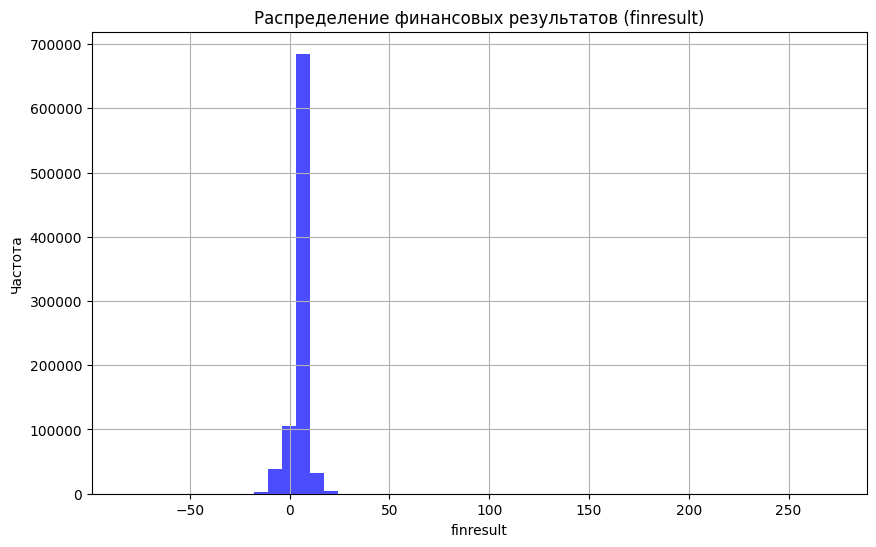

count    868329.000000
mean          5.052214
std           3.925986
min         -81.480000
25%           3.640000
50%           5.040000
75%           6.880000
max         271.600000
Name: finresult, dtype: float64

In [48]:
# Визуализация распределения финансовых результатов
plt.figure(figsize=(10, 6))
plt.hist(sales_df['finresult'], bins=50, color='blue', alpha=0.7)
plt.title('Распределение финансовых результатов (finresult)')
plt.xlabel('finresult')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

fin_result_distribution

In [49]:
# Определение границ сегментов
low_threshold = fin_result_distribution['25%']
high_threshold = fin_result_distribution['75%']

# Функция для определения ценового сегмента
def assign_price_segment(fin_result):
    if fin_result < low_threshold:
        return 'Low'
    elif fin_result > high_threshold:
        return 'High'
    else:
        return 'Medium'

# Присвоение ценовых сегментов
sales_df['price_segment'] = sales_df['finresult'].apply(assign_price_segment)

# Проверка распределения товаров по ценовым сегментам
price_segment_distribution = sales_df['price_segment'].value_counts()

price_segment_distribution

price_segment
Medium    446009
High      216589
Low       205731
Name: count, dtype: int64

Ценовые сегменты были успешно присвоены каждому товару на основе finresult. Распределение товаров по ценовым сегментам следующее:

    Низкий сегмент: 205,731 товар
    Средний сегмент: 446,009 товаров
    Высокий сегмент: 216,589 товаров

In [51]:
# Группировка по ценовым сегментам и анализ продаж
sales_by_segment = sales_df.groupby('price_segment').agg(total_sales=('qty', 'sum'),
                                                         Average_finresult=('finresult', 'mean')).reset_index()
print(sales_by_segment)

  price_segment  total_sales  Average_finresult
0          High       448936           9.062045
1           Low       193973           0.710203
2        Medium       891347           5.107821


### Visualization of distributions bar chart. Sales_df

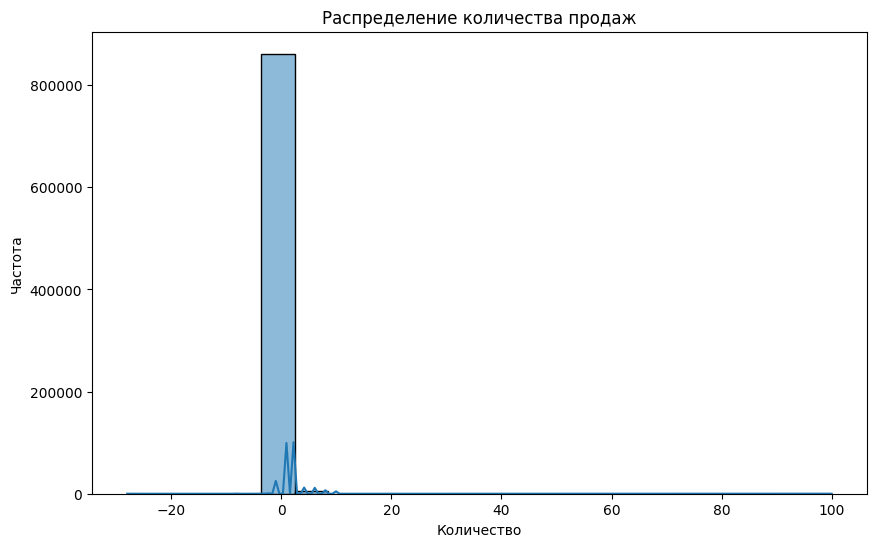

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(sales_df['qty'], kde=True)
plt.title('Распределение количества продаж') # distribution of number of sales
plt.xlabel('Количество') # count of sales
plt.ylabel('Частота') # frequency of sles
plt.show()

In [23]:
sales_df['qty'].value_counts().head(5)

qty
 2    803662
-2     53187
 4      5250
 1      3885
 6       774
Name: count, dtype: int64

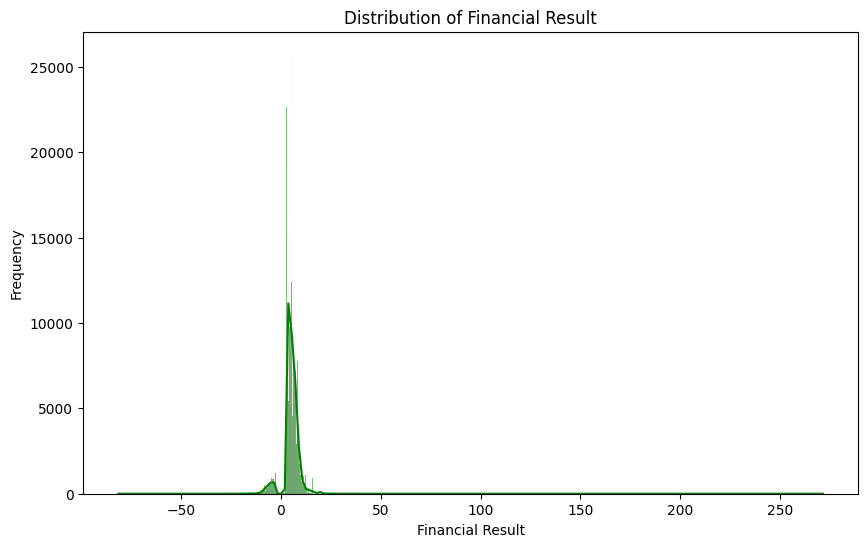

In [24]:
# Distribution of finResult
plt.figure(figsize=(10, 6))
sns.histplot(sales_df['finresult'], kde=True, color='green')
plt.title('Distribution of Financial Result')
plt.xlabel('Financial Result')
plt.ylabel('Frequency')
plt.show()

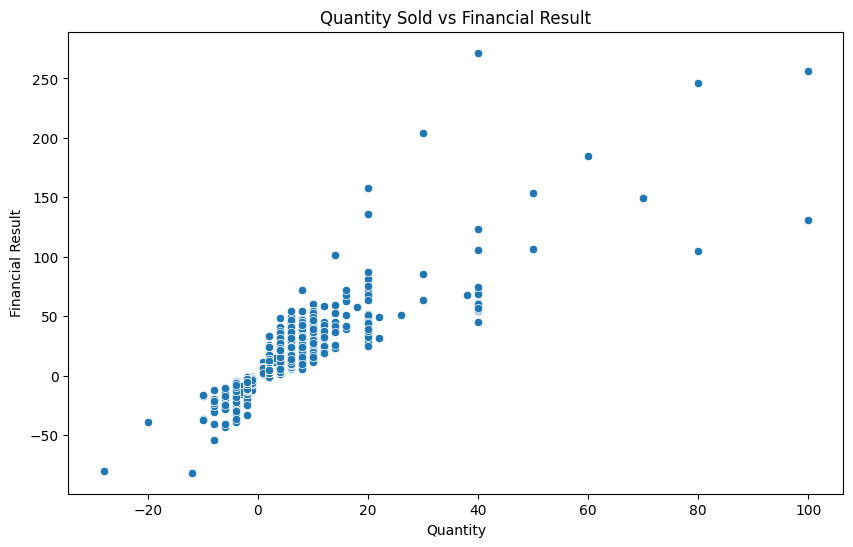

In [25]:
# Scatter plot of qty vs finresult
plt.figure(figsize=(10, 6))
sns.scatterplot(x='qty', y='finresult', data=sales_df)
plt.title('Quantity Sold vs Financial Result')
plt.xlabel('Quantity')
plt.ylabel('Financial Result')
plt.show()

### Visualization of distributions bar chart. Stock_df

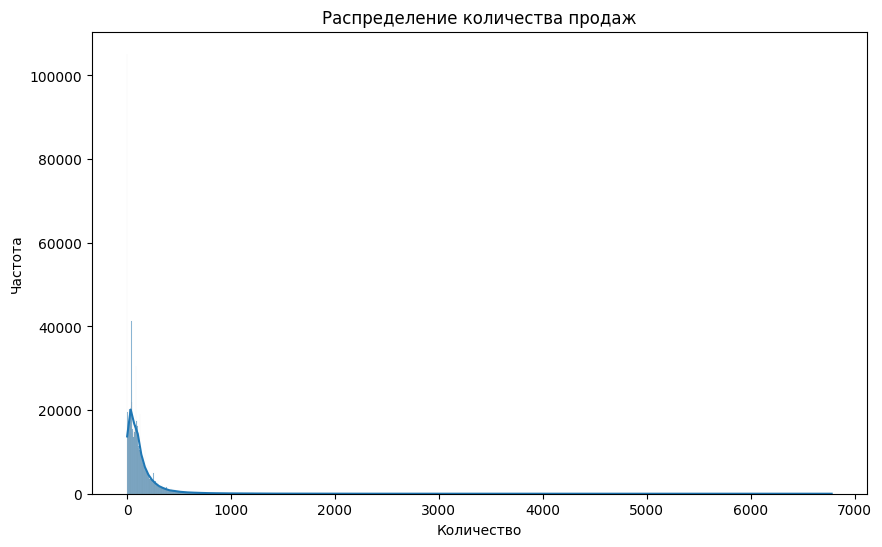

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(stock_df['stock'], kde=True)
plt.title('Распределение количества продаж') # distribution of number of sales
plt.xlabel('Количество') # count of sales
plt.ylabel('Частота') # frequency of sles
plt.show()

### Correlation matrix

In [29]:
# correlation_matrix = sales_df.select_dtypes(include=['float64', 'int64']).corr()
correlation_matrix = sales_df[['qty', 'finresult']].corr()

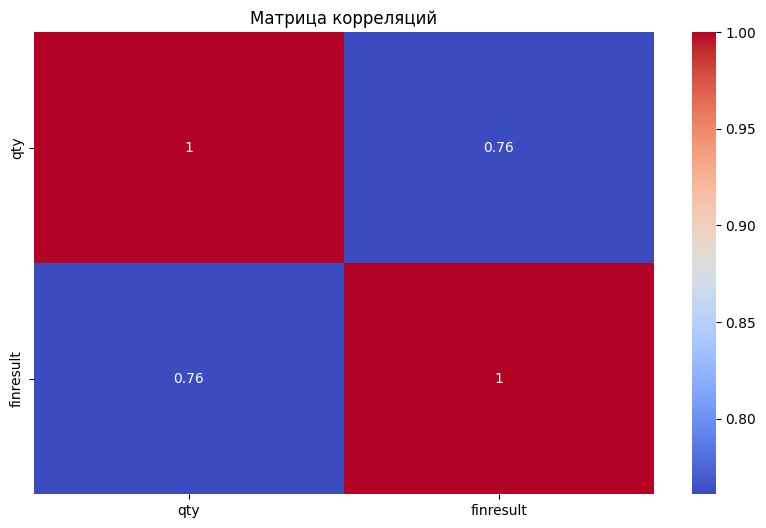

In [30]:
# Визуализация корреляций с помощью тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

---

# Временной Анализ

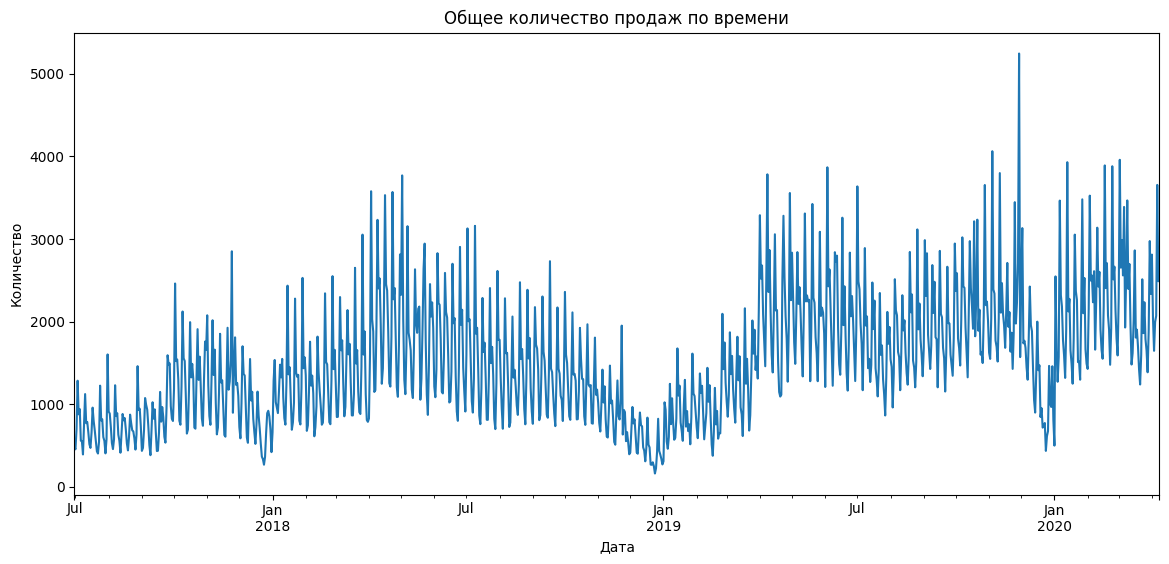

In [31]:
# Анализ трендов и сезонности в данных о продажах
plt.figure(figsize=(14, 6))
sales_df.groupby('date')['qty'].sum().plot()
plt.title('Общее количество продаж по времени')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

In [34]:
sales_df.groupby('date')['qty'].sum().reset_index().sort_values('qty', ascending=False).head(10)

,date,qty
882,2019-11-29,5246
857,2019-11-04,4063
976,2020-03-02,3959
927,2020-01-13,3930
962,2020-02-17,3891
969,2020-02-24,3881
703,2019-06-03,3868
864,2019-11-11,3798
647,2019-04-08,3783
306,2018-05-02,3770


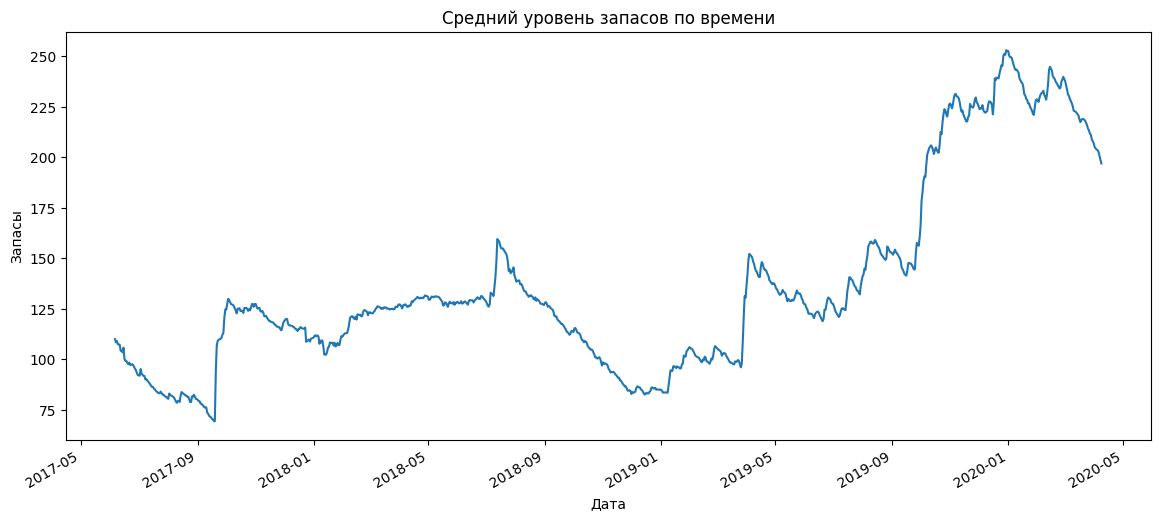

In [35]:
# Анализ трендов и сезонности в данных о запасах
plt.figure(figsize=(14, 6))
stock_df.groupby('date')['stock'].mean().plot()
plt.title('Средний уровень запасов по времени')
plt.xlabel('Дата')
plt.ylabel('Запасы')
plt.show()

In [37]:
stock_df.groupby('date')['stock'].mean().reset_index().sort_values('stock', ascending=False).head(10)

,date,stock
936,2019-12-30,253.005157
937,2019-12-31,252.710010
938,2020-01-01,252.694889
934,2019-12-28,251.218959
935,2019-12-29,250.793405
939,2020-01-02,250.503872
933,2019-12-27,250.200000
940,2020-01-03,249.674935
941,2020-01-04,249.627907
942,2020-01-05,248.971044


### ML

In [59]:
# Подготовка данных для модели
# В этом примере мы используем finresult и article_id как факторы для прогноза qty
X = sales_df[['finresult', 'article_id']] 
y = sales_df['qty']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:


# Инициализация модели линейной регрессии
linear_reg = LinearRegression()

# Обучение модели на обучающей выборке
linear_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = linear_reg.predict(X_test)

# Вычисление метрик качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(0.4864716405255191, 0.5851941232045106)

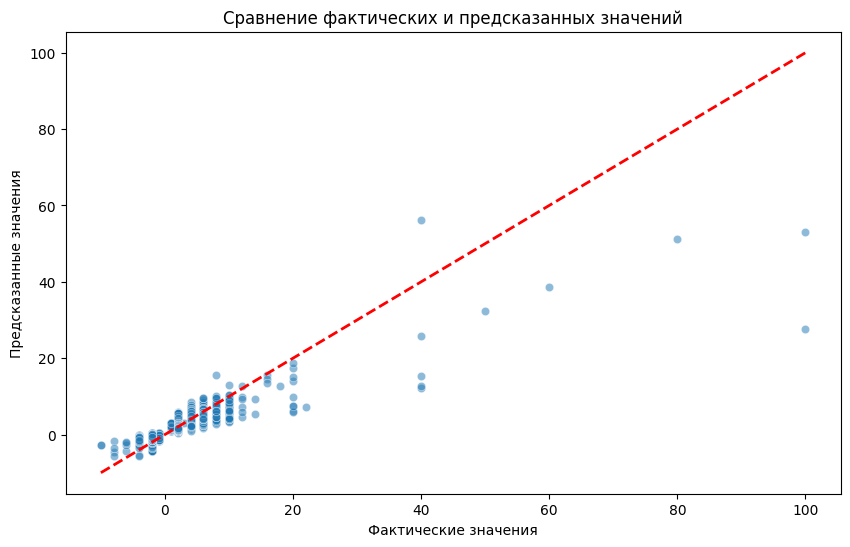

In [61]:
# Создание графика для сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()

#### RandomForestRegressor

In [62]:
# Создание модели случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучение модели
model.fit(X_train, y_train)

# Предсказания модели
predictions = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

mse, mae, rmse

(0.0405038932970952, 0.005229540228561339, 0.2012557907169262)

    Среднеквадратичная ошибка (MSE): 0.0405038932970952
    Средняя абсолютная ошибка (MAE): 0.005229540228561339
    Корень из среднеквадратичной ошибки (RMSE): 0.2012557907169262


### Кластеризация Товаров

C:\Users\Stunez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


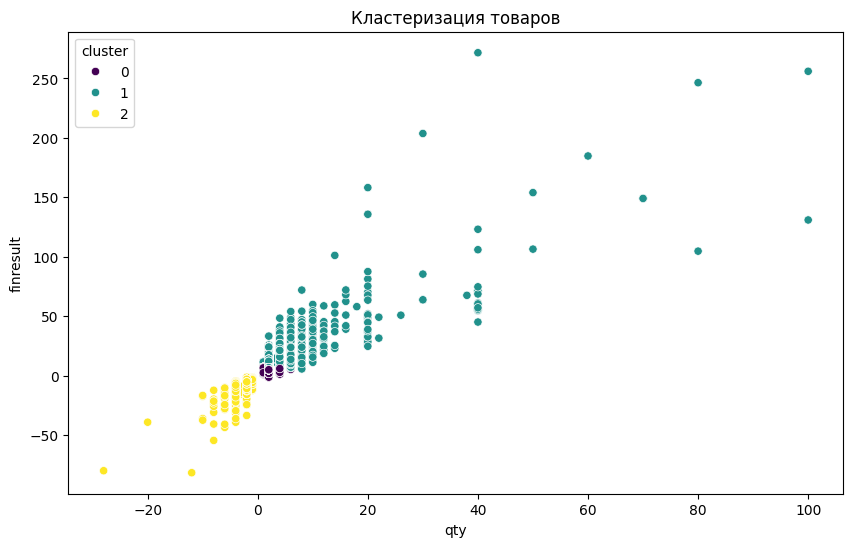

In [38]:
# Выбор переменных для кластеризации
features = sales_df[['qty', 'finresult']]

# Масштабирование данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Добавление меток кластера к исходным данным
sales_df['cluster'] = clusters

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x='qty', y='finresult', hue='cluster', data=sales_df, palette='viridis')
plt.title('Кластеризация товаров')
plt.show()